<a href="https://colab.research.google.com/github/filbertfederico/AI/blob/main/BERT_sentimentGenshin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#im using CPU hehe
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
#do pip install transformers if haven't
# !pip install transformers

In [ ]:
import pandas as pd

df = pd.read_csv("/content/GenshinReview.csv")
df.shape

(4200, 2)

In [ ]:
df.sample(10)

,score,content
1207,2,as a mobile user along with ps there is quite ...
2633,3,i really like and enjoy the game and the lore ...
2381,3,excellent graphic gameplay and music however s...
1776,3,i have been having fun albeit stockholm syndro...
1488,3,i have heard lots of fun thing in this game bu...
2577,3,not yet optimized in mobile bugs and lags ever...
2362,3,i have been playing the game for about a year ...
1315,2,before i begin i wanted to like this game unfo...
1938,3,based on others opinion the game overall is go...
3951,5,great game overall the gameplay is great for a...


In [ ]:
#creating label called sentiment from the score reviews
#1-2: negative
#3: neutral
#4-5: positive

def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 0
    elif rating == 3:
        return 1
    elif rating in [4, 5]:
        return 2

df['sentiment'] = df['score'].apply(map_rating_to_sentiment)

df.head(20)

,score,content,sentiment
0,1,for whatever reason my game used to work just ...,0
1,1,i do like this game but there is seriously thi...,0
2,1,downloaded it once and it worked downloaded it...,0
3,1,my data is mbps when i open this game the ms s...,0
4,1,i have not played the game because of some pro...,0
5,1,i used to love this game but now i am quite di...,0
6,1,resin per day is an atrocious idea that and th...,0
7,1,the looks cool and i would really like to play...,0
8,1,my phone stops working every time i try too pl...,0
9,1,do not bother playing on mobile this is a pc c...,0


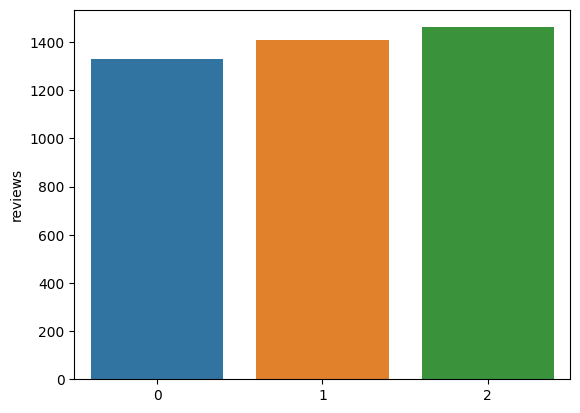

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#for now we have 2000 rows of reviews. we'll add more data perhaps later if the accuracy is still bad.
x = df.sentiment.value_counts()
sns.barplot(x=x.index, y=x)
plt.gca().set_ylabel('reviews')
plt.show()

In [ ]:
sentences = df.content.values
labels = df.sentiment.values

In [ ]:
from transformers import BertTokenizer, AutoTokenizer
#using pretrained bert tokenizer
print("Loading BERT Tokenizer")
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", do_lower_case=True)
# Add 'primogems' to the tokenizer's vocabulary
num_added_toks = tokenizer.add_tokens(['primogems','primos','awesome','awful','rewards','visuals','quests',
                                       'inspiring','gacha','grind', 'grinding','account','optimised','autoplay','kicked','kicks',
                                       'mistakes','kicking','dude','combos','combo','characters','character',
                                       'disappointment','wifi','translation','vulgar','horribly',
                                       'masterpiece','adorable','backbone','misspelling','downloading',
                                       'thoughtful','boring','animations','reccomended','trash','crashing','crashed','crashes'
                                       'definitely','lags','satisfied','traveller','Jean','Sucrose','xiao',
                                       'Venti','Albedo','Beidou','Gorou','Ningguang','Noelle','Zhongli',
                                       'Raiden Shogun','Fischl','Keqing','Lisa','Razor','Barbara','Childe',
                                       'Tartaglia','Mona','Xingqiu','Amber','Bennett','Diluc','Klee','Xiangling',
                                       'Ayaka','Chongyun','Diona','Eula','Ganyu','Kaeya','Qiqi','Rosaria',
                                       'traveller\'s','Jean\'s','Sucrose\'s','xiao\'s','Venti\'s','Albedo\'s',
                                       'Beidou\'s','Gorou\'s','Ningguang\'s','Noelle\'s','Zhongli\'s',
                                       'Raiden Shogun\'s','Fischl\'s','Keqing\'s','Lisa\'s','Razor\'s',
                                       'Barbara\'s','Childe\'s','Tartaglia\'s','Mona\'s','Xingqiu\'s',
                                       'Amber\'s','Bennett\'s','Diluc\'s','Klee\'s','Xiangling\'s',
                                       'Ayaka\'s','Chongyun\'s','Diona\'s','Eula\'s','Ganyu\'s','Kaeya\'s',
                                       'Qiqi\'s','Rosaria\'s','letting','risked','risking','collide','collided',
                                       'lol','sweat','sweating','casually','applies','coompilling','shaders',
                                       'breathtaking','bugged','bugging','teleport','absolutely','scenenary',
                                       'dialogs','hesitant','fave','glitches','lets','insufficient','uninstall',
                                       'uninstalling','honestly','calming','unplayable','delete','delete','liked',
                                       'cheaper','anyways','amazingly','cutscene','lazy','addicting','logging'])


Loading BERT Tokenizer


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
print("Original: ", sentences[0])
#yes it's not perfect, game word terms like primogems are not identified as english word.
print("Tokenized: ", tokenizer.tokenize(sentences[0]))
#tokenization time
print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))
print("Original: ", sentences[0])
#yes it's not perfect, game word terms like primogems are not identified as english word.
print("Tokenized: ", tokenizer.tokenize(sentences[0]))
#tokenization time
print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))



# # Tokenizing sentences and obtaining token IDs
# tokenized_sentences = []
# token_ids = []

# for sent in sentences:
#     tokenized = tokenizer.tokenize(sent)
#     tokenized_sentences.append(tokenized)
#     token_ids.append(tokenizer.convert_tokens_to_ids(tokenized))

# # Create a DataFrame with original sentences, tokenized forms, and token IDs
# output_df = pd.DataFrame({
#     'Original Sentence': sentences,
#     'Tokenized Sentence': tokenized_sentences,
# })

# # Save the DataFrame to a CSV file
# output_df.to_csv('tokenized_sentences.csv', index=False)

Original:  for whatever reason my game used to work just fine except for cutscenes when it crashed and would not play so i had to use geforce but now it just refuses to open it opens up shows a black screen and promptly crashes again i have tried uninstalling and reinstalling took about three hour by the way and restarting my device it just does not work fun game though
Tokenized:  ['for', 'whatever', 'reason', 'my', 'game', 'used', 'to', 'work', 'just', 'fine', 'except', 'for', 'cutscene', 's', 'when', 'it', 'crashed', 'and', 'would', 'not', 'play', 'so', 'i', 'had', 'to', 'use', 'ge', '##force', 'but', 'now', 'it', 'just', 'refuses', 'to', 'open', 'it', 'opens', 'up', 'shows', 'a', 'black', 'screen', 'and', 'pro', '##mp', '##tly', 'crash', '##es', 'again', 'i', 'have', 'tried', 'uninstalling', 'and', 'rein', '##stal', '##ling', 'took', 'about', 'three', 'hour', 'by', 'the', 'way', 'and', 'resta', '##rti', '##ng', 'my', 'device', 'it', 'just', 'does', 'not', 'work', 'fun', 'game', 'th

In [ ]:
input_ids = []

for sent in sentences:
  encoded_sent = tokenizer.encode(
      sent,
      add_special_tokens = True
  )
  input_ids.append(encoded_sent)

print("Original: ", sentences[0])
print("Token IDs: ", input_ids[0])


Token indices sequence length is longer than the specified maximum sequence length for this model (845 > 512). Running this sequence through the model will result in indexing errors


Original:  for whatever reason my game used to work just fine except for cutscenes when it crashed and would not play so i had to use geforce but now it just refuses to open it opens up shows a black screen and promptly crashes again i have tried uninstalling and reinstalling took about three hour by the way and restarting my device it just does not work fun game though
Token IDs:  [101, 10139, 57030, 23065, 11153, 11336, 11173, 10114, 11497, 12125, 12922, 22920, 10139, 106018, 161, 10704, 10197, 83496, 10110, 11008, 10497, 11923, 10297, 151, 10407, 10114, 11868, 25463, 29635, 10502, 11628, 10197, 12125, 84588, 10114, 11481, 10197, 59597, 10700, 15503, 143, 11418, 21496, 10110, 11061, 19135, 49657, 26613, 10165, 12590, 151, 10574, 26806, 106009, 10110, 40783, 47430, 12024, 12384, 10935, 10916, 19141, 10151, 10103, 12140, 10110, 23528, 26538, 10422, 11153, 29067, 10197, 12125, 14893, 10497, 11497, 22271, 11336, 14325, 102]


In [ ]:
print("Max sentence length: ", max([len(sen) for sen in input_ids]))

Max sentence length:  845


In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64

print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 64 values
Padding token: "[PAD]", ID: 0
Done


In [ ]:
input_ids[0]

array([   101,  10139,  57030,  23065,  11153,  11336,  11173,  10114,
        11497,  12125,  12922,  22920,  10139, 106018,    161,  10704,
        10197,  83496,  10110,  11008,  10497,  11923,  10297,    151,
        10407,  10114,  11868,  25463,  29635,  10502,  11628,  10197,
        12125,  84588,  10114,  11481,  10197,  59597,  10700,  15503,
          143,  11418,  21496,  10110,  11061,  19135,  49657,  26613,
        10165,  12590,    151,  10574,  26806, 106009,  10110,  40783,
        47430,  12024,  12384,  10935,  10916,  19141,  10151,  10103])

In [ ]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent]

  attention_mask.append(att_mask)

In [ ]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_labels, test_labels = train_test_split(input_ids,labels, random_state=42, test_size=0.1)
train_mask, test_mask, _, _ = train_test_split(attention_mask, labels, random_state=42, test_size=0.1)

train_input, validation_input, train_labels, validation_labels = train_test_split(train_input, train_labels, random_state= 43, test_size=0.15)
train_mask, validation_mask, _, _ = train_test_split(train_mask, train_mask, random_state=43, test_size=0.15)

In [ ]:
import numpy as np
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (3213, 64)
Label:  (3213,)
Mask:  (3213, 64)

== Validation ==
Input:  (567, 64)
Label:  (567,)
Mask:  (567, 64)

== Test ==
Input:  (420, 64)
Label:  (420,)
Mask:  (420, 64)


In [ ]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "nlptown/bert-base-multilingual-uncased-sentiment",
    num_labels=3,  # Change this to the number of labels in your task
    output_attentions=False,
    output_hidden_states=False,
    ignore_mismatched_sizes=True  # Add this parameter to ignore size mismatches
)
model.resize_token_embeddings(len(tokenizer))
tokenizer.add_special_tokens({'pad_token': '<pad>'})


pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1

In [ ]:
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.
==== Embedding Layer ====
bert.embeddings.word_embeddings.weight                       (106022, 768)
bert.embeddings.position_embeddings.weight                     (512, 768)
bert.embeddings.token_type_embeddings.weight                     (2, 768)
bert.embeddings.LayerNorm.weight                                   (768,)
bert.embeddings.LayerNorm.bias                                     (768,)
==== First Transformers ====
bert.encoder.layer.0.attention.self.query.weight               (768, 768)
bert.encoder.layer.0.attention.self.query.bias                     (768,)
bert.encoder.layer.0.attention.self.key.weight                 (768, 768)
bert.encoder.layer.0.attention.self.key.bias                       (768,)
bert.encoder.layer.0.attention.self.value.weight               (768, 768)
bert.encoder.layer.0.attention.self.value.bias                     (768,)
bert.encoder.layer.0.attention.output.dense.weight             (768, 768)
bert.

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(
    model.parameters(),
    lr = 4e-5,
    eps = 1e-8
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.to(device)

loss_values = []
accuracies = []

for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0

  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):

    # Progress update every 40 batches
    if step % 12 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

    loss = outputs[0]

    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)

  loss_values.append(avg_train_loss)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

  # ===================================
  #             Validation
  # ===================================

  print("Running Validation...")

  t0 = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1

  print("   Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("   Validation took: {:}".format(format_time(time.time() - t0)))

  accuracies.append(eval_accuracy/nb_eval_steps)

print("Training complete!")

======= Epoch 1 / 10 =======
Training...
Batch    12 of   101.     Elapsed: 0:00:05
Batch    24 of   101.     Elapsed: 0:00:09
Batch    36 of   101.     Elapsed: 0:00:13
Batch    48 of   101.     Elapsed: 0:00:17
Batch    60 of   101.     Elapsed: 0:00:21
Batch    72 of   101.     Elapsed: 0:00:25
Batch    84 of   101.     Elapsed: 0:00:29
Batch    96 of   101.     Elapsed: 0:00:33
   Average training loss: 0.86
   Training epoch took: 0:00:35
Running Validation...
   Accuracy: 0.60
   Validation took: 0:00:02
======= Epoch 2 / 10 =======
Training...
Batch    12 of   101.     Elapsed: 0:00:04
Batch    24 of   101.     Elapsed: 0:00:08
Batch    36 of   101.     Elapsed: 0:00:12
Batch    48 of   101.     Elapsed: 0:00:16
Batch    60 of   101.     Elapsed: 0:00:20
Batch    72 of   101.     Elapsed: 0:00:25
Batch    84 of   101.     Elapsed: 0:00:29
Batch    96 of   101.     Elapsed: 0:00:33
   Average training loss: 0.68
   Training epoch took: 0:00:34
Running Validation...
   Accuracy: 0

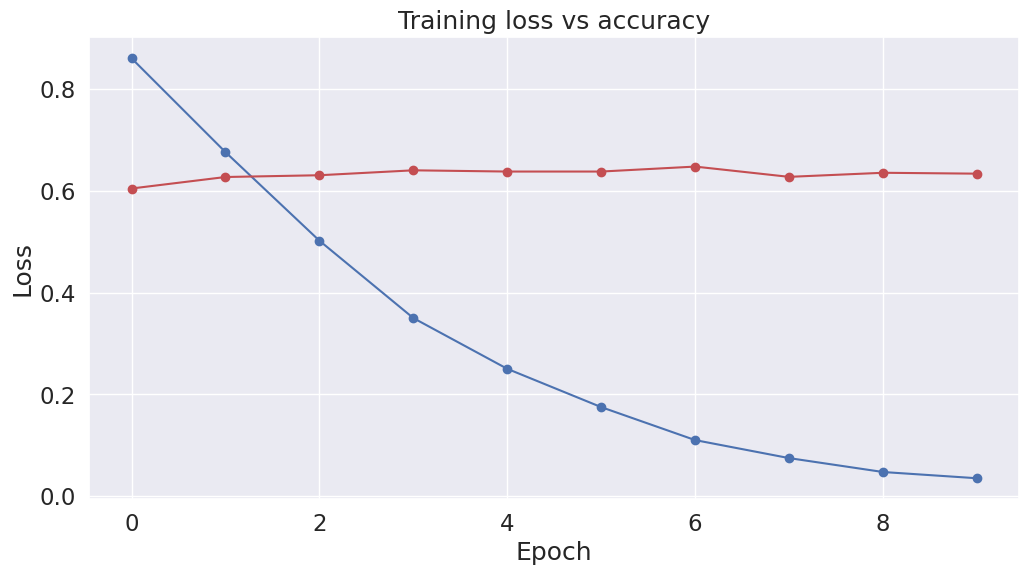

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


#plotting will be continued once this thing is done training bro
import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')
plt.plot(accuracies, 'r-o')
# plt.plot(validation_losses, 'g-o')

plt.title("Training loss vs accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print("finally??? done!!!!")

Predicting labels for 420 test sentences
finally??? done!!!!


In [ ]:
import numpy as np
import pandas as pd

# Assuming prediction and true_labels are lists

# Convert lists to NumPy arrays
prediction_array = np.concatenate(prediction, axis=0)
true_labels_array = np.concatenate(true_labels, axis=0)

# Create a DataFrame
df = pd.DataFrame({
    'Predicted_Labels': np.argmax(prediction_array, axis=1),
    'True_Labels': true_labels_array
})

# Display the DataFrame
print(df)

     Predicted_Labels  True_Labels
0                   1            1
1                   1            1
2                   0            1
3                   1            2
4                   1            0
..                ...          ...
415                 2            2
416                 1            0
417                 0            0
418                 1            2
419                 1            2

[420 rows x 2 columns]


In [ ]:
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score


#convert lists to NumPy arrays
flat_prediction = np.concatenate(prediction, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

#calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(flat_true_labels, np.argmax(flat_prediction, axis=1))

print("MATTHEWS_CC: %.3f" % mcc)

#calculate Accuracy
acc = accuracy_score(flat_true_labels, np.argmax(flat_prediction, axis=1))

print("ACCURACY: %.3f" % acc)

#calculate Precision
precision = precision_score(flat_true_labels, np.argmax(flat_prediction, axis=1), average='weighted')

print("PRECISION: %.3f" % precision)

#calculate Recall
recall = recall_score(flat_true_labels, np.argmax(flat_prediction, axis=1), average='weighted')

print("RECALL: %.3f" % recall)

#calculate F1-Score
f1 = f1_score(flat_true_labels, np.argmax(flat_prediction, axis=1), average='weighted')

print("F1 SCORE: %.3f" % f1)

MATTHEWS_CC: 0.443
ACCURACY: 0.629
PRECISION: 0.642
RECALL: 0.629
F1 SCORE: 0.632


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score

#add a column to df indicating whether the prediction is correct
df['Correct_Prediction'] = df['True_Labels'] == df['Predicted_Labels']

#calculate accuracy
accuracy = accuracy_score(df['True_Labels'], df['Predicted_Labels'])
print("Overall Accuracy: {:.2%}".format(accuracy))

#amount of correct predictions for each sentiment class
for sentiment_class in [0, 1, 2]:  #0 for negative, 1 for neutral, 2 for positive
    correct_predictions = df[df['Correct_Prediction'] & (df['True_Labels'] == sentiment_class)].shape[0]
    total_samples = df[df['True_Labels'] == sentiment_class].shape[0]
    print("Correct {} predictions: {}/{}".format(sentiment_class, correct_predictions, total_samples))

Overall Accuracy: 62.86%
Correct 0 predictions: 84/144
Correct 1 predictions: 92/149
Correct 2 predictions: 88/127


In [ ]:
df.head(10)

,Predicted_Labels,True_Labels,Correct_Prediction
0,1,1,True
1,1,1,True
2,0,1,False
3,1,2,False
4,1,0,False
5,1,1,True
6,1,2,False
7,0,0,True
8,2,2,True
9,0,1,False


In [ ]:
#drop the 'Correct_Prediction' column if not needed
df = df.drop(columns=['Correct_Prediction'])
df.head(10)

,Predicted_Labels,True_Labels
0,1,1
1,1,1
2,0,1
3,1,2
4,1,0
5,1,1
6,1,2
7,0,0
8,2,2
9,0,1
